In [275]:
import tensorflow as tf

In [276]:
import numpy as np

In [277]:
%pip install librosa


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [278]:
import librosa

In [279]:
import matplotlib.pyplot as plt

In [280]:
import os

In [281]:
marvin = os.path.join('marvin','0a7c2a8d_nohash_0.wav')
marvin_f , s = librosa.load(marvin, sr=16000)#normalization done by librosa
print(s)

16000


In [282]:
print(len(marvin_f))

16000


In [283]:
print(marvin_f.min(),marvin_f.max())

-0.28259277 0.3638916


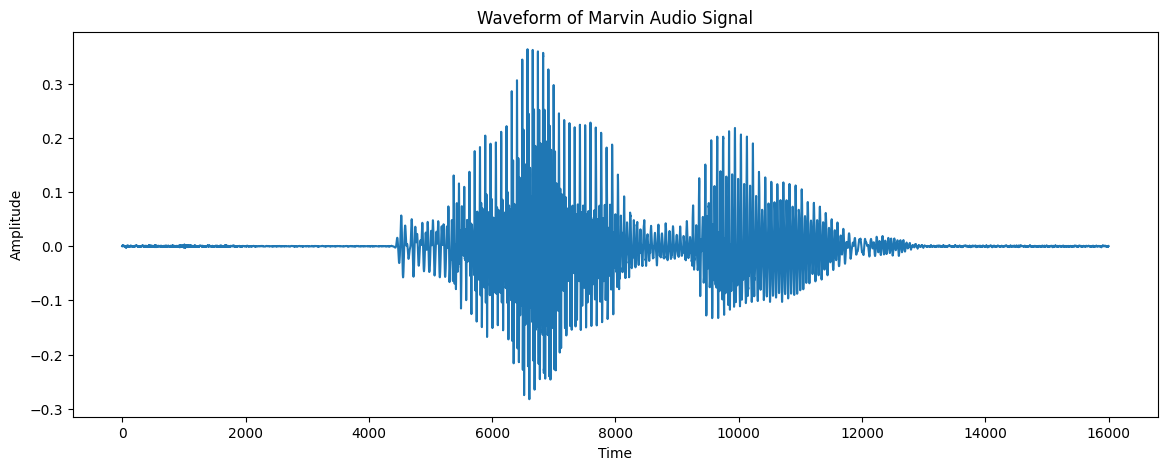

In [284]:
plt.figure(figsize=(14, 5))
plt.plot(marvin_f)
plt.title('Waveform of Marvin Audio Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


In [285]:
noise = os.path.join('doing_the_dishes.wav')
noise_f , _ = librosa.load(noise, sr=16000)
print(len(noise_f))# 95 sec clip

1522930


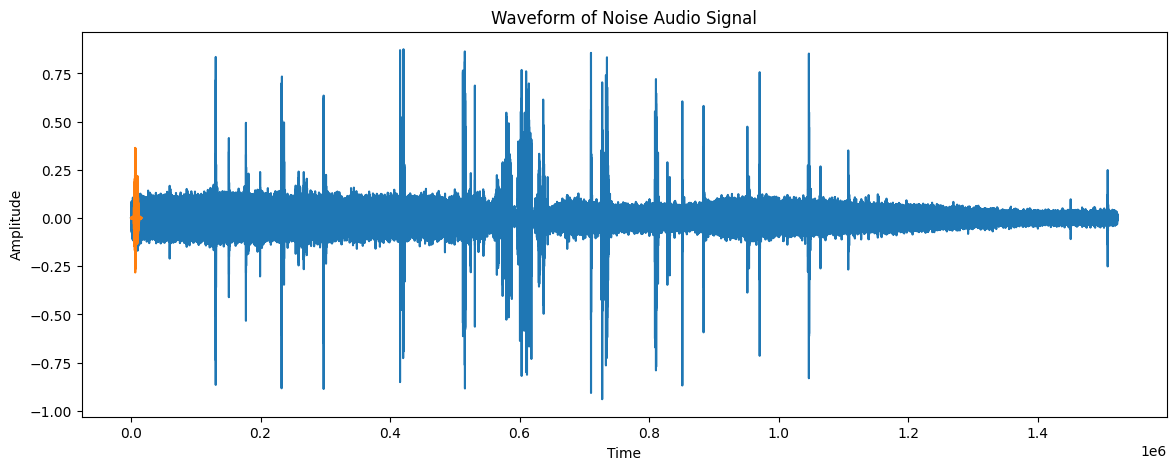

In [286]:
plt.figure(figsize=(14, 5))
plt.plot(noise_f)
plt.plot(marvin_f)
plt.title('Waveform of Noise Audio Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


In [287]:
import soundfile as sf

In [288]:
#spliting the all noise clips to create a negative dataset
noise_clips = [
    'doing_the_dishes.wav',
    'dude_miaowing.wav',
    'exercise_bike.wav',
    'pink_noise.wav',
    'running_tap.wav'
]

output_dir = "noise"
chunk_size = 16000
target_sr = 16000

os.makedirs(output_dir, exist_ok=True)

clip_id = 0

for fname in noise_clips:
    path = os.path.join(fname)

    #librosa → mono + resample to 16kHz
    audio, sr = librosa.load(path, sr=target_sr, mono=True)

    for i in range(0, len(audio), chunk_size):
        chunk = audio[i:i + chunk_size]

        if len(chunk) == chunk_size:
            sf.write(
                os.path.join(output_dir, f"noise_{clip_id}.wav"),
                chunk,
                target_sr
            )
            clip_id += 1
# for i in range(0,len(noise_f),16000):
#     clip = noise_f[i:i+16000]
#     if len(clip) == 16000:
#         sf.write(f"chunk_{i//16000}.wav", clip, s)

In [289]:
noise_1 = os.path.join('noise','noise_22.wav')
noise_1,_ = librosa.load(noise_1, sr=16000)
len(noise_1)

16000

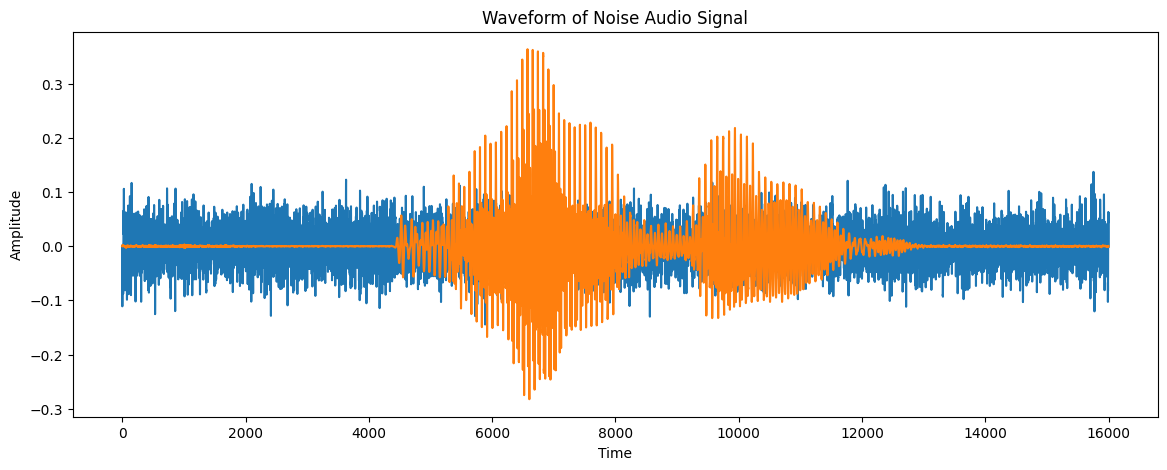

In [290]:
#visualizng the dishes 1 second clip against marvin
plt.figure(figsize=(14, 5))
plt.plot(noise_1)
plt.plot(marvin_f)
plt.title('Waveform of Noise Audio Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [291]:
FRAME_SIZE = 512
HOP_LENGTH = 256

In [292]:
S_scale = librosa.stft(marvin_f, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)

In [293]:
S_scale.shape

(257, 63)

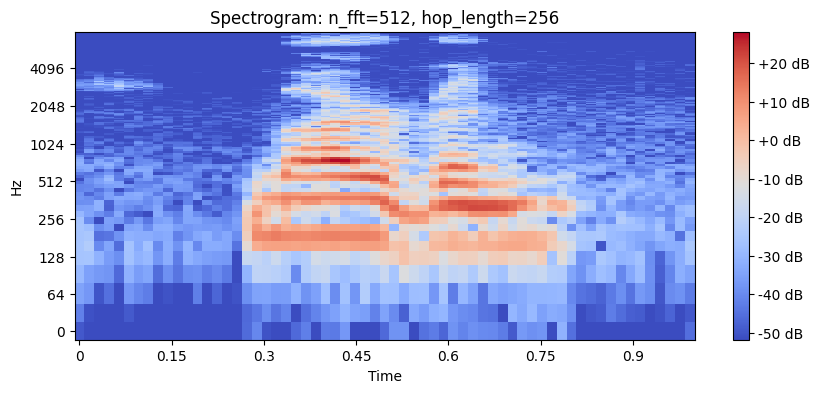

In [294]:
#plotting the spectogram
S_db = librosa.amplitude_to_db(abs(S_scale))

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=s, hop_length=HOP_LENGTH, x_axis='time', y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title(f"Spectrogram: n_fft={FRAME_SIZE}, hop_length={HOP_LENGTH}")
plt.show()

In [295]:
#MFCC's,delta MFCC's, delta delta MFCC's - Extracting features from the audio data
mfcc_marvin = librosa.feature.mfcc(y=marvin_f, sr=16000,n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
mfcc_marvin.shape

(20, 63)

In [296]:
mfcc_marvin_delta = librosa.feature.delta(mfcc_marvin)
mfcc_marvin_delta2 = librosa.feature.delta(mfcc_marvin,order=2)
mfcc_marvin_delta.shape


(20, 63)

In [297]:
mfcc_marvin_delta2.shape

(20, 63)

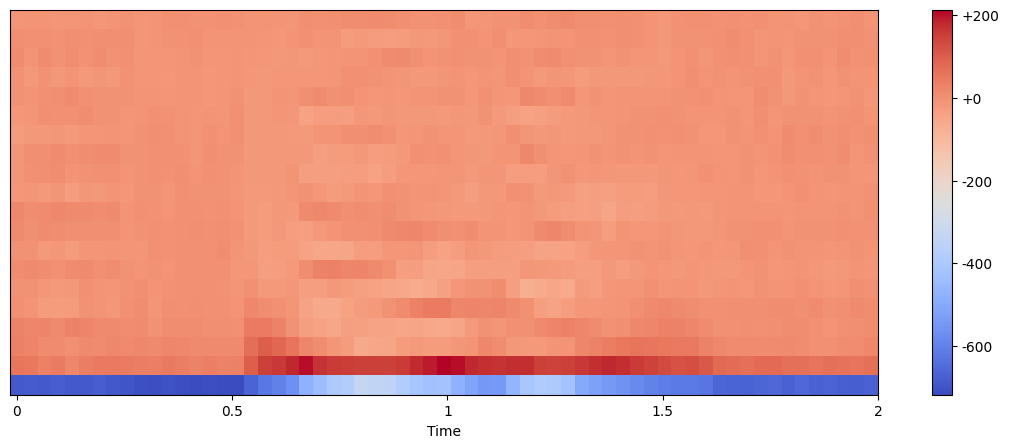

In [298]:
#plotting the MFcc graph for the target audio

plt.figure(figsize=(14, 5))
librosa.display.specshow(mfcc_marvin, x_axis='time',sr = 16000)
plt.colorbar(format='%+2.0f')
plt.show()

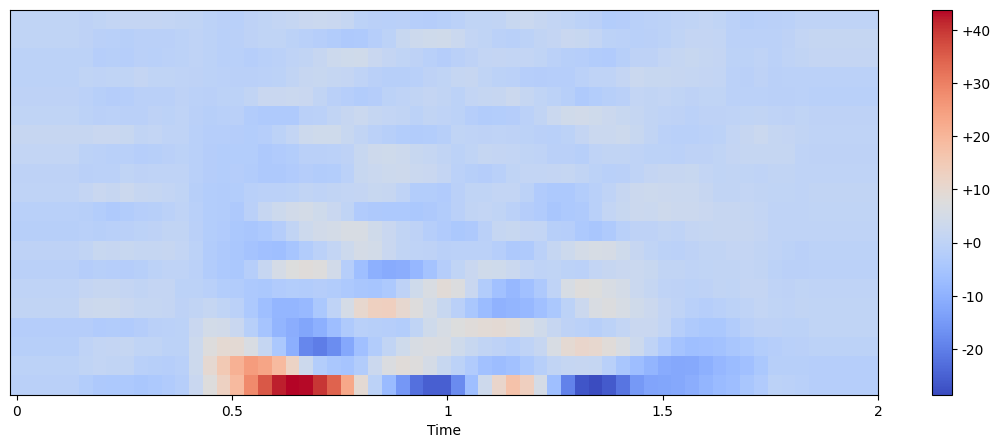

In [299]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(mfcc_marvin_delta, x_axis='time',sr = 16000)
plt.colorbar(format='%+2.0f')
plt.show()

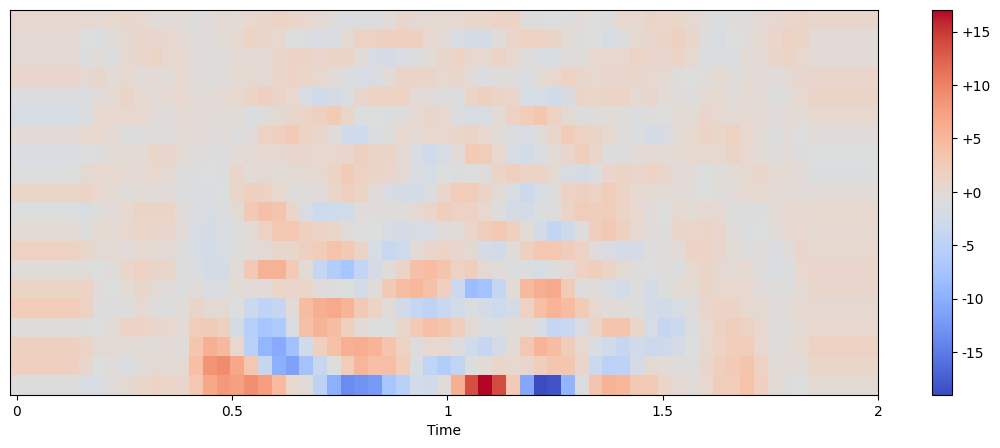

In [300]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(mfcc_marvin_delta2, x_axis='time',sr = 16000)
plt.colorbar(format='%+2.0f')
plt.show()

In [301]:
mfcc_noise = librosa.feature.mfcc(y=noise_1,sr=16000,n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
mfcc_noise.shape

(20, 63)

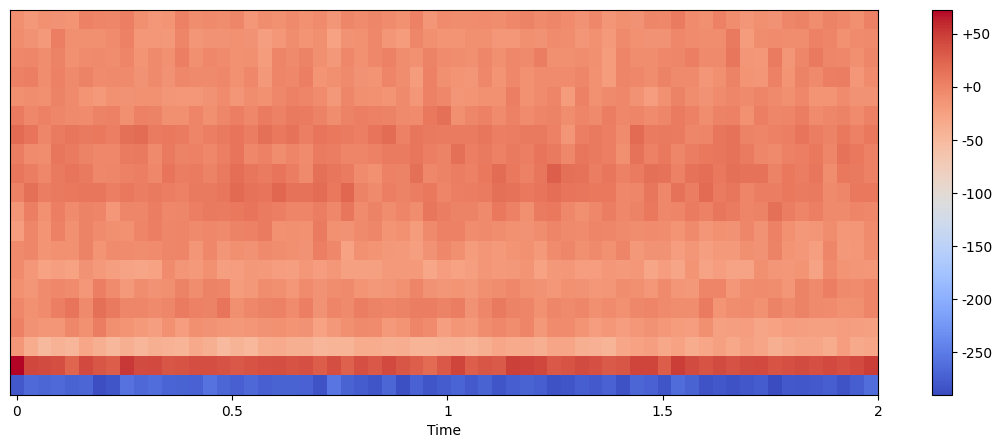

In [302]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(mfcc_noise, x_axis='time',sr = 16000)
plt.colorbar(format='%+2.0f')
plt.show()

In [303]:
#creating a positive and negative dataset using marvin and dishes noise
neg = tf.data.Dataset.list_files(os.path.join('noise') + '/*.wav')
pos = tf.data.Dataset.list_files(os.path.join('marvin') + '/*.wav')

positives = pos.map(lambda x: (x, tf.constant(1)))
negatives = neg.map(lambda x: (x, tf.constant(0)))

In [304]:
positives.as_numpy_iterator().next()

(b'marvin/ba59cab3_nohash_2.wav', np.int32(1))

In [305]:
negatives.as_numpy_iterator().next()

(b'noise/noise_218.wav', np.int32(0))

In [306]:
len(negatives)

338

In [307]:
positives = positives.take(338)
data = positives.concatenate(negatives)

In [308]:
data = data.shuffle(200)
labels = []
for _, y in data.take(100):
    labels.append(y.numpy())

print("positives:", labels.count(1))
print("negatives:", labels.count(0))


positives: 100
negatives: 0


In [309]:
data.as_numpy_iterator().next()

(b'marvin/b575b5fb_nohash_0.wav', np.int32(1))

In [310]:
#creating a  function to extract feature from data
def ex_features(filepath):
    filepath = filepath.numpy().decode("utf-8")
    file,sr = librosa.load(filepath,sr=16000)
    file = file[:16000]

    padding_len = 16000 - len(file)
    if padding_len > 0:
        file = np.pad(file, (0, padding_len))

    #MFCC
    mfcc = librosa.feature.mfcc(y = file , n_mfcc = 13 , sr = sr,n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)


    #Delta MFCC
    delta_mfcc = librosa.feature.delta(mfcc)


    #Delta Delta MFCC
    delta2_mfcc = librosa.feature.delta(mfcc,order=2)


    mfcc = mfcc.T
    delta_mfcc = delta_mfcc.T
    delta2_mfcc = delta2_mfcc.T

    features = np.stack([mfcc, delta_mfcc, delta2_mfcc], axis=-1)

    return features.astype(np.float32)





In [311]:
#creating a function to preprocess the data
def preprocess(path,label):
    feature_matrix = tf.py_function(func=ex_features, inp=[path],Tout = tf.float32)
    feature_matrix.set_shape([63,13,3])
    return feature_matrix , label


In [312]:
data = data.map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)

In [313]:
#data = data.cache()

In [314]:
#looking how its looking
x, y = next(iter(data))
x.shape, y.shape


(TensorShape([63, 13, 3]), TensorShape([]))

In [315]:
data = data.shuffle(300)


In [316]:
#creating a training and validation set
train = data.take(448)
validation = data.skip(448).take(192)



In [317]:
samples, labels = next(iter(train))
labels


<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [318]:
#Mean of training set
sum_ = tf.zeros((13, 3))
count = 0

for x,y in train :            # batch: [B, 63, 13, 3]
    sum_ += tf.reduce_sum(x, axis=[0, 1])   # reduce batch + time
    count += tf.shape(x)[0] * tf.shape(x)[1]

mean = sum_ / tf.cast(count, tf.float32)
mean.shape



2026-01-25 17:44:07.377171: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


TensorShape([13, 3])

In [319]:
sum_std = tf.zeros((13, 3))
count_std = 0

for x,y in train :            # batch: [B, 63, 13, 3]
    sum_std += (tf.reduce_sum(tf.square(x), axis=[0, 1]))  # reduce batch + time
    count_std += tf.shape(x)[0] * tf.shape(x)[1]

second_moment = sum_std / tf.cast(count, tf.float32)
second_moment

<tf.Tensor: shape=(13, 3), dtype=float32, numpy=
array([[1.8272568e+04, 2.1454847e+01, 4.0479083e+00],
       [1.8272568e+04, 2.1454847e+01, 4.0479083e+00],
       [1.8272568e+04, 2.1454847e+01, 4.0479083e+00],
       [1.8272568e+04, 2.1454847e+01, 4.0479083e+00],
       [1.8272568e+04, 2.1454847e+01, 4.0479083e+00],
       [1.8272568e+04, 2.1454847e+01, 4.0479083e+00],
       [1.8272568e+04, 2.1454847e+01, 4.0479083e+00],
       [1.8272568e+04, 2.1454847e+01, 4.0479083e+00],
       [1.8272568e+04, 2.1454847e+01, 4.0479083e+00],
       [1.8272568e+04, 2.1454847e+01, 4.0479083e+00],
       [1.8272568e+04, 2.1454847e+01, 4.0479083e+00],
       [1.8272568e+04, 2.1454847e+01, 4.0479083e+00],
       [1.8272568e+04, 2.1454847e+01, 4.0479083e+00]], dtype=float32)>

In [320]:
#standard deviation of training set

std = tf.sqrt(second_moment - mean**2)
std.shape


TensorShape([13, 3])

In [321]:
#Normalization function
EPS = 1e-6

def normalize(x_d,y_d):
    x_d = (x_d - mean) / (std+EPS)
    return x_d , y_d


In [322]:
train = train.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

In [323]:
#testing their normalization

for x, y in train.take(1):
    print(tf.reduce_mean(x, axis=[0,1]))  # ≈ 0
    print(tf.math.reduce_std(x, axis=[0,1]))  # ≈ 1


tf.Tensor([ 0.02590824  0.15649985 -0.2298922 ], shape=(3,), dtype=float32)
tf.Tensor([0.7321474 1.6514657 2.1342912], shape=(3,), dtype=float32)


In [324]:
#Normalizing the validation set
validation = validation.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

In [325]:

train = train.cache()
validation = validation.cache()

In [326]:
train = train.batch(32)
validation = validation.batch(32)

In [327]:
train = train.prefetch(tf.data.AUTOTUNE)
validation = validation.prefetch(tf.data.AUTOTUNE)

In [328]:
sample = next(iter(train))
print(sample[0].shape)


(32, 63, 13, 3)


2026-01-25 17:44:09.051922: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [333]:
#creating the CNN
# Clear any old models and free memory
tf.keras.backend.clear_session()


model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(63, 13, 3)),

    tf.keras.layers.Conv2D(32, (5, 3),strides=(1, 1),padding='same',activation='relu',),
    tf.keras.layers.DepthwiseConv2D((3, 3),padding='same',activation='relu',),
    tf.keras.layers.Conv2D(64, (1, 1),activation='relu',),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [334]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-3,
    clipnorm=1.0
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)


In [335]:
steps_per_epoch = 448 // 32
validation_steps = 192 // 32

history = model.fit(
    train,
    validation_data=validation,
    epochs=10,
    steps_per_epoch=14,
    validation_steps=6
)

print(model.summary())




Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6808 - precision: 0.6319 - recall: 1.0000 - val_loss: 0.6948 - val_precision: 0.3958 - val_recall: 1.0000
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6479 - precision: 0.6319 - recall: 1.0000 - val_loss: 0.6875 - val_precision: 0.3958 - val_recall: 1.0000
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6053 - precision: 0.6319 - recall: 1.0000 - val_loss: 0.6745 - val_precision: 0.3958 - val_recall: 1.0000
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5453 - precision: 0.6319 - recall: 1.0000 - val_loss: 0.6549 - val_precision: 0.3958 - val_recall: 1.0000
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4830 - precision: 0.6319 - recall: 1.0000 - val_loss: 0.6215 - val_precision: 0.3958 - val_recall: 1.0000
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4313 - precision: 0.6377 - recall: 1.0000 - val_loss: 0.5747 - val_precision: 0.4294 - val_recall: 1.0000
Epo

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 63, 13, 32)     │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 63, 13, 32)     │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 63, 13, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,909 (46.52 KB)

 Trainable params: 3,969 (15.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,940 (31.02 KB)

None


In [337]:
loss, precision, recall = model.evaluate(validation)
print(f"Validation precision: {precision:.3f}, recall: {recall:.3f}")



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3235 - precision: 0.8850 - recall: 1.0000
Validation precision: 0.854, recall: 1.000
